# Projeto Final - Aprendizagem de Máquina 2025-2

Fluxo:
1. FASE 1: Executa busca de hiperparâmetros para LightGBM, XGBoost, CatBoost, SAINT e ASKL2 e salva `best_params`.
2. FASE 2: Para cada dataset e cada modelo, instanciamos a partir dos `best_params`, treinamos no conjunto de treino completo, geramos `y_pred`, `y_prob`, calculamos `runtime` e salvamos os artefatos em `artifacts/`.
3. Model comparison: Agrupamos os artefatos salvos para calcular métricas agregadas e exportar `evaluation_results.csv`.

## Modelos Implementados

- **Modelos Clássicos (Baselines)**: LightGBM, XGBoost, CatBoost
- **AutoML**: AutoGluon, Auto-Sklearn 2.0 (ASKL2)
- **Modelo Deep Learning**: SAINT (Self-Attention and Intersample Transformer)

**Referência do SAINT:** https://github.com/Actis92/lit-saint

## Instalando os pacotes

É necessário instalar as dependências na ordem descrita para funcionar. É utilizado o `python 3.8` para instalar o SAINT corretamente. Aqui são instalados os seguintes pacotes:
- `lit-saint`: Implementação do modelo SAINT.
- `openml`: Biblioteca para carregar os datasets do OpenML.
- `autogluon`: Modelo de automl utilizado para comparação.
- `lightgbm`, `xgboost` e `catboost`: Modelos clássicos para comparação.
- `auto-sklearn`: Modelo de automl utilizado para comparação.
- `scikit-learn`: Biblioteca de machine learning.
- `seaborn` e `matplotlib`: Bibliotecas para visualização dos resultados.
- `scikit-posthocs`: Biblioteca para testes estatísticos pós-hoc.

In [33]:
%pip install spacy==3.7.0 spacy-legacy==3.0.12 pandas==1.5.3 openml==0.14.2 \
    lit-saint==0.4.1 lightgbm==3.3.5 xgboost==1.7.6 catboost==1.2.5 autogluon==0.8.3

E1201 07:00:59.767140553   55471 backup_poller.cc:136]       Run client channel backup poller: UNKNOWN:pollset_work {created_time:"2025-12-01T07:00:59.76676219-03:00", children:[UNKNOWN:Bad file descriptor {created_time:"2025-12-01T07:00:59.766706015-03:00", errno:9, os_error:"Bad file descriptor", syscall:"epoll_wait"}]}
  Using cached scikit_learn-1.3.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
auto-sklearn 0.15.0 requires scikit-learn<0.25.0,>=0.24.0, but you have scikit-learn 1.3.2 which is incompatible.
N

In [2]:
%pip install auto-sklearn==0.15.0 numpy==1.24.4 matplotlib==3.7.5 \
    seaborn==0.13.2 scikit-posthocs==0.8.0 scipy==1.10.1

Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-0.24.2-cp38-cp38-manylinux2010_x86_64.whl.metadata (9.8 kB)
Using cached scikit_learn-0.24.2-cp38-cp38-manylinux2010_x86_64.whl (24.9 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-core 0.8.3 requires scikit-learn<1.4.1,>=1.1, but you have scikit-learn 0.24.2 which is incompatible.
autogluon-features 0.8.3 requires scikit-learn<1.4.1,>=1.1, but you have scikit-learn 0.24.2 which is incompatible.
autogluon-multimodal 0.8.3 requires scikit-learn<1.4.1,>=1.1, but you have scikit-learn 0.24.2 which is incompatible.
autogluon-tabular 0.8.3 requires scikit-learn<1.4.1,>=1.1, 

## Configurando o ambiente

Faz as seguintes alterações:
1. Ignora avisos para manter o notebook limpo.
2. Define uma semente aleatória para garantir reprodutibilidade.
3. Define o máximo de iterações na busca de hiperparâmetros.
4. Define o número de folds para o cross validation.

In [38]:
import pathlib

RANDOM_STATE = 42
N_JOBS = -1

SEARCH_ITERATIONS = 20
CV_FOLDS = 5

DATASETS_PATH = pathlib.Path('./datasets')
OPENML_CC18_ID = 99
NUM_DATASETS = 30

# Diretórios para armazenamento
TRAINED_MODELS_DIR = pathlib.Path('trained_models')
TRAINED_MODELS_DIR.mkdir(exist_ok=True)

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import json
import pickle
import time

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

warnings.filterwarnings('ignore')
np.random.seed(RANDOM_STATE)

## Funções Utilitárias para Salvar/Carregar Modelos

Essas funções servem para salvar e carregar modelos treinados, facilitando a reutilização sem a necessidade de retreinamento.

In [40]:
from typing import Any, Dict, List, Mapping, Optional
from datetime import datetime, timezone
from dataclasses import dataclass
from pathlib import Path
import re

ARTIFACT_ROOT = Path("artifacts")
ARTIFACT_VERSION = 2

@dataclass
class ArtifactBundle:
    """Container usado ao ler artefatos do disco."""
    model_key: str
    dataset_name: str
    dataset_slug: str
    metadata: Dict[str, Any]
    arrays: Dict[str, np.ndarray]
    path: Path

def _slugify(value: str) -> str:
    value = value.strip().lower()
    value = re.sub(r"[^a-z0-9]+", "-", value)
    value = re.sub(r"-+", "-", value).strip("-")
    return value or "dataset"

def _ensure_dir(path: Path) -> None:
    path.mkdir(parents=True, exist_ok=True)

def _as_serializable(obj: Any) -> Any:
    if isinstance(obj, np.generic):
        return obj.item()
    if isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    return obj

def get_dataset_dir(model_key: str, dataset_name: str) -> Path:
    slug = _slugify(dataset_name)
    return ARTIFACT_ROOT / model_key.lower() / slug

def artifact_exists(model_key: str, dataset_name: str) -> bool:
    dataset_dir = get_dataset_dir(model_key, dataset_name)
    return (
        dataset_dir.joinpath('metadata.json').exists()
        and dataset_dir.joinpath('predictions.npz').exists()
    )

def artifact_output_dir(model_key: str, dataset_name: str) -> str:
    return str(get_dataset_dir(model_key, dataset_name))

def write_artifact_bundle(
    *,
    model_key: str,
    dataset_name: str,
    y_true: np.ndarray,
    y_pred: Optional[np.ndarray],
    y_prob: Optional[np.ndarray],
    hyperparams: Optional[Mapping[str, Any]] = None,
    runtime_seconds: Optional[float] = None,
) -> Path:
    """Escreve metadados + arrays de predição para uma combinação dataset/modelo."""
    dataset_dir = get_dataset_dir(model_key, dataset_name)
    _ensure_dir(dataset_dir)

    metadata: Dict[str, Any] = {
        "artifact_version": ARTIFACT_VERSION,
        "model_key": model_key,
        "dataset_name": dataset_name,
        "dataset_slug": dataset_dir.name,
        "timestamp_utc": datetime.now(timezone.utc).isoformat(),
    }

    if hyperparams is not None:
        metadata["hyperparams"] = {
            k: _as_serializable(v) for k, v in hyperparams.items()
        }
    if runtime_seconds is not None:
        metadata["runtime_seconds"] = float(runtime_seconds)

    metadata_path = dataset_dir / "metadata.json"
    with metadata_path.open("w", encoding="utf-8") as fp:
        json.dump(metadata, fp, indent=2, ensure_ascii=False)

    arrays: Dict[str, np.ndarray] = {
        "y_true": np.asarray(y_true),
    }
    if y_pred is not None:
        arrays["y_pred"] = np.asarray(y_pred)
    if y_prob is not None:
        arrays["y_prob"] = np.asarray(y_prob)

    np.savez_compressed(dataset_dir / "predictions.npz", **arrays)
    return dataset_dir

def load_artifact_bundle(model_key: str, dataset_name: Optional[str] = None) -> List[ArtifactBundle]:
    """Carrega todos os artefatos armazenados para ``model_key`` (opcionalmente filtrados)."""
    base_dir = ARTIFACT_ROOT / model_key.lower()
    if not base_dir.exists():
        return []

    bundles: List[ArtifactBundle] = []
    for dataset_dir in sorted(base_dir.iterdir()):
        if not dataset_dir.is_dir():
            continue
        if dataset_name and _slugify(dataset_name) != dataset_dir.name:
            continue
        metadata_path = dataset_dir / "metadata.json"
        predictions_path = dataset_dir / "predictions.npz"
        if not metadata_path.exists() or not predictions_path.exists():
            continue
        with metadata_path.open("r", encoding="utf-8") as fp:
            metadata = json.load(fp)
        arrays = dict(np.load(predictions_path, allow_pickle=False))
        bundles.append(
            ArtifactBundle(
                model_key=model_key,
                dataset_name=metadata.get("dataset_name", dataset_dir.name),
                dataset_slug=dataset_dir.name,
                metadata=metadata,
                arrays=arrays,
                path=dataset_dir,
            )
        )
    return bundles

def load_all_artifacts() -> Dict[str, List[ArtifactBundle]]:
    """Retorna todos os artefatos armazenados agrupados por chave do modelo."""
    artifacts: Dict[str, List[ArtifactBundle]] = {}
    if not ARTIFACT_ROOT.exists():
        return artifacts
    for model_dir in ARTIFACT_ROOT.iterdir():
        if not model_dir.is_dir():
            continue
        model_key = model_dir.name
        artifacts[model_key] = load_artifact_bundle(model_key)
    return artifacts



## Carregamento de Dados

Carrega os 30 menores datasets do OpenML para tarefas de classificação do CC18.

Esses datasets são salvos em um mapping onde a chave é o nome do dataset e o valor é o dataframe com as devidas features e um campo 'target' para as predições verdadeiras.

In [41]:
import openml

if not DATASETS_PATH.exists():
    print("Fetching datasets from OpenML...")
    suite = openml.study.get_suite(suite_id=OPENML_CC18_ID)
    datasets_df = openml.datasets.list_datasets(data_id=suite.data, output_format='dataframe')

    datasets_df_sorted = datasets_df.sort_values(by='NumberOfInstances')
    top_datasets = datasets_df_sorted.head(NUM_DATASETS)

    datasets_memory = {}
    for idx, row in top_datasets.iterrows():
        dataset_id = row['did']
        dataset_name = row['name']
        print(f"Fetching {dataset_name} (ID: {dataset_id})...")
        try:
            dataset = openml.datasets.get_dataset(dataset_id)
            X, y, _, _ = dataset.get_data(
                target=dataset.default_target_attribute,
                dataset_format='dataframe'
            )
            if y is not None:
                X['target'] = y
            datasets_memory[dataset_name] = X
        except Exception as exc:
            print(f"Failed to load {dataset_name}: {exc}")
else:
    print("Loading datasets from disk...")
    datasets_memory = {
        p.stem: pd.read_csv(p) for i, p in enumerate(DATASETS_PATH.glob('*.csv')) if i < NUM_DATASETS
    }

print(f"Done! {len(datasets_memory)} datasets available.")

Loading datasets from disk...
Done! 30 datasets available.


## Divisão Train/Test

Cada dataset é dividido em:
- **Conjunto de treino**: 70%
- **Conjunto de teste**: 30%
- **Seed**: Definido para reprodutibilidade

Os conjuntos de treino e teste são armazenados em um mapping para cada dataset:
- Chave: Nome do dataset
- Valor: Dicionário com:
    - 'X_train': Features de treino
    - 'X_test': Features de teste
    - 'y_train': Rótulos de treino
    - 'y_test': Rótulos de teste

In [42]:
from sklearn.model_selection import train_test_split

train_test_splits = {}
for dataset_name, df in datasets_memory.items():
    X = df.drop(columns=['target'])
    y = df['target']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=RANDOM_STATE
    )

    train_test_splits[dataset_name] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }

    print(f"{dataset_name}: treino={len(X_train)} | teste={len(X_test)}")

print(f"Total: {len(train_test_splits)} datasets")

qsar-biodeg: treino=738 | teste=317
pc3: treino=1094 | teste=469
vowel: treino=693 | teste=297
car: treino=1209 | teste=519
credit-approval: treino=483 | teste=207
analcatdata_dmft: treino=557 | teste=240
mfeat-factors: treino=1400 | teste=600
cylinder-bands: treino=378 | teste=162
pc4: treino=1020 | teste=438
eucalyptus: treino=515 | teste=221
cmc: treino=1031 | teste=442
MiceProtein: treino=756 | teste=324
wdbc: treino=398 | teste=171
analcatdata_authorship: treino=588 | teste=253
steel-plates-fault: treino=1358 | teste=583
semeion: treino=1115 | teste=478
banknote-authentication: treino=960 | teste=412
cnae-9: treino=756 | teste=324
balance-scale: treino=437 | teste=188
ilpd: treino=408 | teste=175
climate-model-simulation-crashes: treino=378 | teste=162
blood-transfusion-service-center: treino=523 | teste=225
pc1: treino=776 | teste=333
credit-g: treino=700 | teste=300
tic-tac-toe: treino=670 | teste=288
diabetes: treino=537 | teste=231
breast-w: treino=489 | teste=210
vehicle: tre

## Pré-processamento

O pré-processamento aplica:
1. **LabelEncoder**: Para a variável alvo
2. **OrdinalEncoder**: Para variáveis categóricas
3. **StandardScaler**: Para variáveis numéricas
4. **PCA**: Para redução de dimensionalidade

In [43]:

from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA

def preprocess_all_datasets(train_test_splits):
    """
    Pré-processa todos os datasets de uma vez.
    
    Realiza:
    1. Codificação do target (LabelEncoder).
    2. Codificação de categóricas (OrdinalEncoder).
    3. Normalização de numéricas (StandardScaler).
    4. Redução de dimensionalidade (PCA) se features > 300.
    
    Args:
        train_test_splits (dict): Dicionário contendo X_train, X_test, y_train, y_test para cada dataset.
        
    Returns:
        dict: Dicionário mapeando nome do dataset -> dados processados (X_train_encoded, etc).
    """
    processed_memory = {}
    print("Iniciando pré-processamento de todos os datasets...")
    
    for dataset_name, splits in train_test_splits.items():
        print(f"  Processando {dataset_name}...")
        X_train = splits['X_train']
        y_train = splits['y_train']
        X_test = splits['X_test']
        y_test = splits['y_test']

        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y_train)
        y_test_encoded = le.transform(y_test)

        X_train_encoded = X_train.copy()
        X_test_encoded = X_test.copy()
        categorical_cols = X_train_encoded.select_dtypes(include=['object', 'category']).columns.tolist()

        if categorical_cols:
            oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
            X_train_encoded[categorical_cols] = oe.fit_transform(X_train_encoded[categorical_cols].astype(str))
            X_test_encoded[categorical_cols] = oe.transform(X_test_encoded[categorical_cols].astype(str))

        scaler = StandardScaler()
        numeric_cols = X_train_encoded.select_dtypes(include=[np.number]).columns
        X_train_scaled = X_train_encoded.copy()
        X_test_scaled = X_test_encoded.copy()
        if len(numeric_cols) > 0:
            X_train_scaled[numeric_cols] = scaler.fit_transform(X_train_encoded[numeric_cols])
            X_test_scaled[numeric_cols] = scaler.transform(X_test_encoded[numeric_cols])

        # Dimensionality Reduction
        if X_train_scaled.shape[1] > 100:
            n_components = min(100, X_train_scaled.shape[0])
            print(f"    Aplicando PCA: {X_train_scaled.shape[1]} -> {n_components} features")
            pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
            X_train_pca = pca.fit_transform(X_train_scaled)
            X_test_pca = pca.transform(X_test_scaled)
            
            pca_cols = [f'pca_{i}' for i in range(X_train_pca.shape[1])]
            X_train_encoded = pd.DataFrame(X_train_pca, columns=pca_cols, index=X_train.index)
            X_test_encoded = pd.DataFrame(X_test_pca, columns=pca_cols, index=X_test.index)
            
            X_train_scaled = X_train_encoded.copy()
            X_test_scaled = X_test_encoded.copy()

        processed_memory[dataset_name] = {
            'X_train_encoded': X_train_encoded,
            'X_test_encoded': X_test_encoded,
            'X_train_scaled': X_train_scaled,
            'X_test_scaled': X_test_scaled,
            'y_train_encoded': y_train_encoded,
            'y_test_encoded': y_test_encoded,
            'y_train_original': y_train.reset_index(drop=True),
            'y_test_original': y_test.reset_index(drop=True),
            'label_encoder': le
        }
        
    print(f"Pré-processamento concluído para {len(processed_memory)} datasets.")
    return processed_memory

processed_datasets_memory = preprocess_all_datasets(train_test_splits)

Iniciando pré-processamento de todos os datasets...
  Processando qsar-biodeg...
  Processando pc3...
  Processando vowel...
  Processando car...
  Processando credit-approval...
  Processando analcatdata_dmft...
  Processando mfeat-factors...
    Aplicando PCA: 216 -> 100 features
  Processando cylinder-bands...
  Processando pc4...
  Processando eucalyptus...
  Processando cmc...
  Processando MiceProtein...
  Processando wdbc...
  Processando analcatdata_authorship...
  Processando steel-plates-fault...
  Processando semeion...
    Aplicando PCA: 256 -> 100 features
  Processando banknote-authentication...
  Processando cnae-9...
    Aplicando PCA: 856 -> 100 features
  Processando balance-scale...
  Processando ilpd...
  Processando climate-model-simulation-crashes...
  Processando blood-transfusion-service-center...
  Processando pc1...
  Processando credit-g...
  Processando tic-tac-toe...
  Processando diabetes...
  Processando breast-w...
  Processando vehicle...
  Processando 

In [44]:
import json

def save_best_params(model_key, dataset_name, best_params, best_score):
    """Guarda os melhores hiperparâmetros e score em disco."""
    params_dir = TRAINED_MODELS_DIR / model_key / 'best_params'
    params_dir.mkdir(parents=True, exist_ok=True)
    params_path = params_dir / f"{dataset_name}.json"
    
    data = {'params': best_params, 'score': best_score}
    
    with params_path.open('w', encoding='utf-8') as fp:
        json.dump(data, fp, indent=2, default=str)

def load_best_params(model_key, dataset_name):
    """Carrega os melhores hiperparâmetros e score, caso existam."""
    params_path = TRAINED_MODELS_DIR / model_key / 'best_params' / f"{dataset_name}.json"
    if not params_path.exists():
        return None
    with params_path.open('r', encoding='utf-8') as fp:
        data = json.load(fp)
    
    return data

---
# Busca de Hiperparâmetros e Treinamento de Modelos

Nesta fase, para cada modelo:
1. Busca os melhores hiperparâmetros usando RandomizedSearchCV
2. Treina o modelo final com esses hiperparâmetros


### LightGBM, XGBoost e CatBoost

Realiza a otimização de hiperparâmetros para os seguintes modelos usando RandomizedSearchCV com validação cruzada estratificada:
- **LightGBM**: Número de folhas, profundidade, taxa de aprendizado
- **XGBoost**: Profundidade, taxa de aprendizado, número de estimadores
- **CatBoost**: Profundidade, iterações, taxa de aprendizado

In [45]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform
from joblib import parallel_backend

from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb

param_spaces = {
    'lightgbm': {
        'num_leaves': randint(20, 151),
        'max_depth': randint(3, 16),
        'learning_rate': loguniform(1e-2, 3e-1),
        'n_estimators': randint(50, 401),
        'min_child_samples': randint(5, 101),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5),
        'reg_alpha': loguniform(1e-8, 10),
        'reg_lambda': loguniform(1e-8, 10)
    },
    'xgboost': {
        'max_depth': randint(3, 16),
        'learning_rate': loguniform(1e-2, 3e-1),
        'n_estimators': randint(50, 401),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5),
        'min_child_weight': randint(1, 11),
        'gamma': loguniform(1e-8, 1.0),
        'reg_alpha': loguniform(1e-8, 10),
        'reg_lambda': loguniform(1e-8, 10)
    },
    'catboost': {
        'depth': randint(3, 11),
        'border_count': randint(32, 256),
        'learning_rate': loguniform(1e-2, 3e-1),
        'iterations': randint(50, 401),
        'l2_leaf_reg': uniform(1, 9),
        'random_strength': uniform(0, 10),
        'bagging_temperature': uniform(0, 1)
    },
    'saint': {
        'depth': randint(3, 11),
        'heads': randint(4, 9),
        'dropout': uniform(0.0, 0.5),
        'learning_rate': loguniform(1e-4, 1e-2),
        'batch_size': randint(64, 257),
        'epochs': randint(5, 21)
    }
}

def instantiate_baseline_model(model_name, best_params = {}):
    """Instancia um modelo clássico (LightGBM/XGBoost/CatBoost) a partir de best_params."""
    if model_name == 'lightgbm':
        model = lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1,
                                   **best_params)
    elif model_name == 'xgboost':
        model = xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss',
                                  use_label_encoder=False, **best_params)
    elif model_name == 'catboost':
        model = CatBoostClassifier(random_state=RANDOM_STATE,
                                   verbose=0, **best_params)
    else:
        raise ValueError(f"Modelo desconhecido: {model_name}")
    return model

def search_baseline_models(dataset_name, processed_data):
	"""
	Busca apenas os melhores hiperparâmetros para modelos clássicos
	e retorna um mapeamento {model_name: {'best_params': ...}}.
	Não salva modelos treinados em disco.
	"""
	X_train = processed_data['X_train_encoded']
	y_train = processed_data['y_train_encoded']

	min_class_count = pd.Series(y_train).value_counts().min()
	n_splits = max(min(CV_FOLDS, min_class_count), 2)
	cv_strategy = StratifiedKFold(n_splits=n_splits, shuffle=True,
									random_state=RANDOM_STATE)

	estimators = {
		'lightgbm': lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1),
		'xgboost': xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', use_label_encoder=False),
		'catboost': CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)
	}

	results = {}
	for model_key, estimator in estimators.items():
		print(f"  {model_key}: buscando hiperparâmetros...", end=' ', flush=True)
		
		# Check if already exists
		existing = load_best_params(model_key, dataset_name)
		if existing:
			results[model_key] = existing['params']
			print(f" {existing['score']:.4f}")
			continue

		search = RandomizedSearchCV(
			estimator=estimator,
			param_distributions=param_spaces[model_key],
			n_iter=SEARCH_ITERATIONS,
			cv=cv_strategy,
			n_jobs=1 if model_key == 'catboost' else N_JOBS,
			scoring='accuracy',
			random_state=RANDOM_STATE,
			verbose=0
		)

		with parallel_backend('threading'):
			search.fit(X_train, y_train)

		results[model_key] = search.best_params_
		save_best_params(model_key, dataset_name, search.best_params_, search.best_score_)
		print(f" {search.best_score_:.4f}")

	return results

best_params_by_dataset = {}
print("FASE 1: BUSCA DE HIPERPARÂMETROS")
for dataset_idx, (dataset_name, processed_data) in enumerate(processed_datasets_memory.items(), 1):
	print(f"\n[{dataset_idx}/{len(processed_datasets_memory)}] {dataset_name}")
	print("-" * 80)

	best_params_by_dataset[dataset_name] = search_baseline_models(dataset_name, processed_data)

FASE 1: BUSCA DE HIPERPARÂMETROS

[1/30] qsar-biodeg
--------------------------------------------------------------------------------
  lightgbm: buscando hiperparâmetros... 

 0.8712
  xgboost: buscando hiperparâmetros...  0.8780
  catboost: buscando hiperparâmetros...  0.8685

[2/30] pc3
--------------------------------------------------------------------------------
  lightgbm: buscando hiperparâmetros...  0.9022
  xgboost: buscando hiperparâmetros...  0.9031
  catboost: buscando hiperparâmetros...  0.9040

[3/30] vowel
--------------------------------------------------------------------------------
  lightgbm: buscando hiperparâmetros...  0.8976
  xgboost: buscando hiperparâmetros...  0.8630
  catboost: buscando hiperparâmetros...  0.9524

[4/30] car
--------------------------------------------------------------------------------
  lightgbm: buscando hiperparâmetros...  0.9917
  xgboost: buscando hiperparâmetros...  0.9901
  catboost: buscando hiperparâmetros...  0.9942

[5/30] credit-approval
--------------------------------------------------------------------------------
  lightgbm: buscando hiperparâmetros...  0.8821
  xgboost: buscando hiperparâmetro

### SAINT (lit-saint)

O SAINT (Self-Attention and Intersample Transformer) é um modelo de deep learning específico para dados tabulares. Utiliza atenção entre amostras e features.
A busca por pela melhor Dimensionalidade, número de cabeças de atenção, taxa de aprendizado

In [46]:
from lit_saint.config import (NetworkConfig, TransformerConfig, TrainConfig,
                              OptimizerConfig)
from lit_saint import Saint, SaintConfig, SaintDatamodule, SaintTrainer
from sklearn.metrics import accuracy_score
from pytorch_lightning import Trainer
import torch.nn.functional as F
import torch

def prepare_saint_dataframe(X, y, validation_ratio=0.2, min_val_samples=10, 
                            random_state=None):
    """Cria DataFrame com 'target' e 'split' para o SaintDatamodule."""
    if isinstance(y, pd.Series):
        if y.dtype == bool:
            y = y.astype(int)

    df = X.copy().reset_index(drop=True)
    df['target'] = y.reset_index(drop=True)
    df['split'] = 'train'

    if len(df) <= 1:
        return df

    val_size = max(int(len(df) * validation_ratio), min_val_samples)
    if val_size >= len(df):
        val_size = max(1, len(df) // 5) or 1

    val_idx = df.sample(n=val_size, random_state=random_state).index
    df.loc[val_idx, 'split'] = 'validation'
    return df


def extract_prediction_array(predictions):
    if isinstance(predictions, dict):
        for key in ('predictions', 'logits', 'probs'):
            if key in predictions:
                predictions = predictions[key]
                break
        else:
            for value in predictions.values():
                if hasattr(value, 'shape'):
                    predictions = value
                    break
            else:
                raise ValueError(f"Não foi possível encontrar previsões nas chaves: {list(predictions.keys())}")

    if hasattr(predictions, 'detach'):
        predictions = predictions.detach()
    if hasattr(predictions, 'cpu'):
        predictions = predictions.cpu()
    if hasattr(predictions, 'numpy'):
        predictions = predictions.numpy()
    return predictions


def saint_array_to_probabilities(preds_array):
    tensor = torch.tensor(preds_array).float()
    if tensor.ndim == 1 or (tensor.ndim == 2 and tensor.shape[1] == 1):
        probs = torch.sigmoid(tensor).numpy().flatten()
        return np.vstack([1 - probs, probs]).T
    return torch.softmax(tensor, dim=1).numpy()


def predictions_to_labels(predictions):
    predictions = np.asarray(predictions)
    if predictions.ndim == 1:
        return (predictions > 0.5).astype(int)
    return np.argmax(predictions, axis=1)

class FixSaint(Saint):
    """
    Modelo para resolver o problema de quando os labels do dataset
    estão com (N, 1) em vez de (N) e a transformação de float -> int
    """

    def _classification_loss(self, y_pred, target):
        # Fix target shape: (N, 1) -> (N)
        if target.ndim == 2 and target.shape[1] == 1:
            target = target.squeeze(1)

        # Fix target type: float -> long (int)
        target = target.long()
        return F.cross_entropy(y_pred, target)

class SklSaint():
	"""Wrapper para o SAINT funcionar como um modelo sklearn-like."""

	def __init__(self, saint_model: Saint, saint_trainer: SaintTrainer,
              	 data_module: SaintDatamodule):
		self.saint_model = saint_model
		self.data_module = data_module
		self.saint_trainer = saint_trainer

	def predict(self, X):
		predictions = self.saint_trainer.predict(
			model=self.saint_model,
			df=X,
			datamodule=self.data_module
		)
		preds_array = extract_prediction_array(predictions)
		y_pred = predictions_to_labels(preds_array)
		return y_pred

	def predict_proba(self, X):
		predictions = self.saint_trainer.predict(
			model=self.saint_model,
			df=X,
			datamodule=self.data_module
		)
		preds_array = extract_prediction_array(predictions)
		y_prob = saint_array_to_probabilities(preds_array)
		return y_prob

def initialize_saint(params: dict, df_train: pd.DataFrame, n_classes: int):
    """
    Inicializa o SAINT com os hiperparâmetros fornecidos.

    Args:
        params (dict): Dicionário com os hiperparâmetros do SAINT.
        df_train (pd.DataFrame): DataFrame com os dados de treinamento.
        n_classes: Quantidade de classes que serão preditas

    Returns:
        SAINT: Instância do SAINT treinada.
        SaintTrainer: Instância do SaintTrainer treinada.
        SaintDatamodule: Instância do SaintDatamodule.
    """
    data_module = SaintDatamodule(
        df=df_train,
        target='target',
        split_column='split'
    )
    saint_config = SaintConfig(
        network=NetworkConfig(
            transformer=TransformerConfig(
                depth=params['depth'],
                heads=params['heads'],
                dropout=params['dropout']
            )
        ),
        train=TrainConfig(
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            optimizer=OptimizerConfig(
                learning_rate=params['learning_rate']
            )
        )
    )
    saint_model = FixSaint(
        categories=data_module.categorical_dims,
        continuous=data_module.numerical_columns,
        config=saint_config,
        dim_target=n_classes
    )
    trainer = Trainer(
        max_epochs=params['epochs'],
        logger=False,
        num_sanity_val_steps=0,
        enable_progress_bar=False,
        enable_model_summary=False
    )
    saint_trainer = SaintTrainer(trainer=trainer)
    saint_trainer.fit(
        model=saint_model,
        datamodule=data_module,
        enable_pretraining=False
    )
    return SklSaint(saint_model, saint_trainer, data_module)

def train_and_evaluate_saint(params, processed_data):
    """
    Treina o modelo SAINT com os melhores hiperparâmetros e avalia no conjunto
    de teste. Retorna o modelo SAINT treinado, probabilidades previstas, rótulos
    previstos e tempo de treinamento.

	Args:
		params (dict): Dicionário com os melhores hiperparâmetros do SAINT.
		processed_data (dict): Dados processados para treino/teste.
  
	Returns:
		dict: Dicionário contendo 'y_prob', 'y_pred' e 'time'.
    """
    X_test_features = processed_data['X_test_scaled']
    y_train_encoded = processed_data['y_train_encoded']
    X_train_features = processed_data['X_train_scaled']

    df_train_full = prepare_saint_dataframe(
        X=X_train_features,
        y=pd.Series(y_train_encoded),
        min_val_samples=1,
        validation_ratio=0.05,
        random_state=RANDOM_STATE
    )

    n_classes = len(np.unique(y_train_encoded))
    start_time = time.time()
    saint_model = initialize_saint(
        params, df_train_full, n_classes
    )

    y_pred = saint_model.predict(X_test_features)
    y_prob = saint_array_to_probabilities(y_pred)
    end_time = time.time()

    return {
        'y_prob': y_prob,
        'y_pred': y_pred,
        'time': end_time - start_time
    }


def search_saint_params(processed_data):
    """
    Realiza busca randômica por melhores hiperparâmetros para o SAINT,
    sem re-treinar final do modelo.
    """
    X_train_features = processed_data['X_train_scaled']
    y_train_encoded = processed_data['y_train_encoded']

    df_train_full = prepare_saint_dataframe(
        X=X_train_features,
        y=pd.Series(y_train_encoded),
        validation_ratio=0.2,
        min_val_samples=10,
        random_state=RANDOM_STATE
    )

    n_classes = len(np.unique(y_train_encoded))
    best_score = -np.inf
    best_params = None

    print(f"  SAINT search - train_size={len(X_train_features)} | df_train_full={len(df_train_full)}")
    for trial_idx in range(SEARCH_ITERATIONS):
        params = {
            'depth': int(param_spaces['saint']['depth'].rvs()),
            'heads': int(param_spaces['saint']['heads'].rvs()),
            'epochs': int(param_spaces['saint']['epochs'].rvs()),
            'dropout': float(param_spaces['saint']['dropout'].rvs()),
            'batch_size': int(param_spaces['saint']['batch_size'].rvs()),
            'learning_rate': float(param_spaces['saint']['learning_rate'].rvs()),
        }

        try:
            saint_model = initialize_saint(
                params, df_train_full, n_classes)
            df_val = df_train_full[df_train_full['split'] == 'validation'].copy()
            y_pred = saint_model.predict(df_val.drop(columns=['target', 'split']))
            y_true = df_val['target'].values.astype(int)
            score = accuracy_score(y_true, y_pred)

            if score > best_score:
                best_score = score
                best_params = params
        except Exception as e:
            print(f"  Erro SAINT (tentativa {trial_idx + 1}): {e}")
            continue

    if best_params is None:
        print("✗ Não foi possível treinar SAINT (nenhuma tentativa válida).")
        return None, None

    return best_params, best_score

print("FASE 1: BUSCA DE HIPERPARÂMETROS (apenas pesquisa)")
for dataset_idx, (dataset_name, processed_data) in enumerate(processed_datasets_memory.items(), 1):
	print(f"\n[{dataset_idx}/{len(processed_datasets_memory)}] {dataset_name}")
	print("-" * 80)

	best_params = None
	existing = load_best_params('saint', dataset_name)
	if existing:
		best_params = existing['params']
		print("Melhor pontuação para o SAINT:", existing['score'])

	else:
		best_params, best_score = search_saint_params(processed_data)
		if best_params:
			print("Melhor pontuação para o SAINT:", best_score)
			save_best_params('saint', dataset_name, best_params, best_score)

	best_params_by_dataset[dataset_name]['saint'] = best_params

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


FASE 1: BUSCA DE HIPERPARÂMETROS (apenas pesquisa)

[1/30] qsar-biodeg
--------------------------------------------------------------------------------
  SAINT search - train_size=738 | df_train_full=738
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.


The following cols will not be used because they have a not supported data type:  []


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.8503401360544217

[2/30] pc3
--------------------------------------------------------------------------------
  SAINT search - train_size=1094 | df_train_full=1094
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.8899082568807339

[3/30] vowel
--------------------------------------------------------------------------------
  SAINT search - train_size=693 | df_train_full=693
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.6231884057971014

[4/30] car
--------------------------------------------------------------------------------
  SAINT search - train_size=1209 | df_train_full=1209
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.9377593360995851

[5/30] credit-approval
--------------------------------------------------------------------------------
  SAINT search - train_size=483 | df_train_full=483
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.9166666666666666

[6/30] analcatdata_dmft
--------------------------------------------------------------------------------
  SAINT search - train_size=557 | df_train_full=557
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.22522522522522523

[7/30] mfeat-factors
--------------------------------------------------------------------------------
  SAINT search - train_size=1400 | df_train_full=1400
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.


The following cols will not be used because they have a not supported data type:  []


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.6

[8/30] cylinder-bands
--------------------------------------------------------------------------------
  SAINT search - train_size=378 | df_train_full=378
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.7866666666666666

[9/30] pc4
--------------------------------------------------------------------------------
  SAINT search - train_size=1020 | df_train_full=1020
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.8970588235294118

[10/30] eucalyptus
--------------------------------------------------------------------------------
  SAINT search - train_size=515 | df_train_full=515
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.5631067961165048

[11/30] cmc
--------------------------------------------------------------------------------
  SAINT search - train_size=1031 | df_train_full=1031
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.5631067961165048

[12/30] MiceProtein
--------------------------------------------------------------------------------
  SAINT search - train_size=756 | df_train_full=756
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.6490066225165563

[13/30] wdbc
--------------------------------------------------------------------------------
  SAINT search - train_size=398 | df_train_full=398
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.9493670886075949

[14/30] analcatdata_authorship
--------------------------------------------------------------------------------
  SAINT search - train_size=588 | df_train_full=588
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.9829059829059829

[15/30] steel-plates-fault
--------------------------------------------------------------------------------
  SAINT search - train_size=1358 | df_train_full=1358
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.5645756457564576

[16/30] semeion
--------------------------------------------------------------------------------
  SAINT search - train_size=1115 | df_train_full=1115
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.336322869955157

[17/30] banknote-authentication
--------------------------------------------------------------------------------
  SAINT search - train_size=960 | df_train_full=960
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 1.0

[18/30] cnae-9
--------------------------------------------------------------------------------
  SAINT search - train_size=756 | df_train_full=756
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.


The following cols will not be used because they have a not supported data type:  []


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.5165562913907285

[19/30] balance-scale
--------------------------------------------------------------------------------
  SAINT search - train_size=437 | df_train_full=437
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.9195402298850575

[20/30] ilpd
--------------------------------------------------------------------------------
  SAINT search - train_size=408 | df_train_full=408
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.654320987654321

[21/30] climate-model-simulation-crashes
--------------------------------------------------------------------------------
  SAINT search - train_size=378 | df_train_full=378
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.9066666666666666

[22/30] blood-transfusion-service-center
--------------------------------------------------------------------------------
  SAINT search - train_size=523 | df_train_full=523
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.7403846153846154

[23/30] pc1
--------------------------------------------------------------------------------
  SAINT search - train_size=776 | df_train_full=776
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.9483870967741935

[24/30] credit-g
--------------------------------------------------------------------------------
  SAINT search - train_size=700 | df_train_full=700
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.75

[25/30] tic-tac-toe
--------------------------------------------------------------------------------
  SAINT search - train_size=670 | df_train_full=670
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.7835820895522388

[26/30] diabetes
--------------------------------------------------------------------------------
  SAINT search - train_size=537 | df_train_full=537
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.8037383177570093

[27/30] breast-w
--------------------------------------------------------------------------------
  SAINT search - train_size=489 | df_train_full=489
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.979381443298969

[28/30] vehicle
--------------------------------------------------------------------------------
  SAINT search - train_size=592 | df_train_full=592
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.6440677966101694

[29/30] dresses-sales
--------------------------------------------------------------------------------
  SAINT search - train_size=350 | df_train_full=350
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Melhor pontuação para o SAINT: 0.5857142857142857

[30/30] kc2
--------------------------------------------------------------------------------
  SAINT search - train_size=365 | df_train_full=365
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=13` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=7` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=12` reached.


Melhor pontuação para o SAINT: 0.8493150684931506


---
# FASE 2: Avaliação Final e Geração de Artefatos

Nesta fase:
1. Carrega os melhores hiperparâmetros de `trained_models/.../best_params`
2. Treina os modelos no conjunto de treino completo
3. Gera predições no conjunto de teste
4. Calcula métricas (accuracy, runtime, etc.)
5. Salva artefatos finais em `artifacts/` para análise

> Observação: AutoGluon é tratado especialmente devido à sua natureza AutoML (o `.fit()` já realiza uma busca interna). Para AutoGluon o processo de avaliação é executado na FASE 2 (treino + avaliação), enquanto a busca separada não é tão direta quanto para os demais modelos.

In [47]:
from autosklearn.experimental.askl2 import AutoSklearn2Classifier
from autogluon.tabular import TabularPredictor

ASKL_TIME_BUDGET = 300  # segundos
ASKL_PER_RUN_LIMIT = 120  # segundos por configuração
ASKL_MEMORY_LIMIT = 6144  # MB

def train_and_evaluate_askl2(dataset_name, processed_data):
    """
    Treina o AutoSklearn2Classifier e retorna predictions + runtime.
    """
    X_train = processed_data['X_train_scaled'].to_numpy()
    y_train = processed_data['y_train_encoded']
    X_test = processed_data['X_test_scaled'].to_numpy()

    classifier = AutoSklearn2Classifier(
        time_left_for_this_task=ASKL_TIME_BUDGET,
        per_run_time_limit=ASKL_PER_RUN_LIMIT,
        memory_limit=ASKL_MEMORY_LIMIT,
        n_jobs=N_JOBS,
        seed=RANDOM_STATE,
    )

    start_time = time.time()

    classifier.fit(X_train, y_train)
    y_prob = classifier.predict_proba(X_test)
    y_pred = classifier.predict(X_test)

    total_time = time.time() - start_time


    return {
     'y_prob': y_prob,
     'y_pred': y_pred,
     'time': total_time,
    }

def train_and_evaluate_autogluon(dataset_name, processed_data):
	"""
	Treina o AutoGluon TabularPredictor com os params fornecidos e retorna predictions + runtime.
	"""
	X_test = processed_data['X_test_encoded'].copy()
	X_train = processed_data['X_train_encoded'].copy()
	X_train['target'] = processed_data['y_train_encoded']

	predictor = TabularPredictor(
		label='target',
		problem_type='multiclass',
		eval_metric='accuracy',
		verbosity=0,
		path=str(TRAINED_MODELS_DIR / 'autogluon' / dataset_name)
	)

	start_time = time.time()

	predictor.fit(
		train_data=X_train,
		time_limit=300,
		presets='best_quality'
	)

	y_prob = predictor.predict_proba(X_test).to_numpy()
	y_pred = predictor.predict(X_test)

	total_time = time.time() - start_time

	return {
     'y_prob': y_prob,
     'y_pred': y_pred,
     'time': total_time,
    }

print("FASE 2: AVALIAÇÃO FINAL E GERAÇÃO DE ARTEFATOS")
for dataset_idx, (dataset_name, processed_data) in enumerate(processed_datasets_memory.items(), 1):
	print(f"\n[{dataset_idx}/{len(processed_datasets_memory)}] {dataset_name}")
	print("-" * 80)

	for model_key in ['lightgbm', 'xgboost', 'catboost', 'saint', 'autogluon', 'askl2']:
		print(f"Validando o Modelo: {model_key}")
		best_params = None
		if model_key not in ['askl2', 'autogluon']:
			best_params = best_params_by_dataset[dataset_name][model_key]
		
		if artifact_exists(model_key, dataset_name):
			print(f"    → Artefatos {model_key} salvos em {artifact_output_dir(model_key, dataset_name)}")
			continue

		if model_key in ['lightgbm', 'xgboost', 'catboost']:
			model = instantiate_baseline_model(model_key, best_params)

			X_train = processed_data['X_train_encoded']
			y_train = processed_data['y_train_encoded']
			X_test = processed_data['X_test_encoded']

			start_time = time.time()
			model.fit(X_train, y_train)

			y_prob = model.predict_proba(X_test)
			y_pred = model.predict(X_test)

			runtime = time.time() - start_time
		elif model_key == 'saint':
			res = train_and_evaluate_saint(best_params, processed_data)
			y_pred = res['y_pred']
			y_prob = res['y_prob']
			runtime = res['time']
		elif model_key == 'askl2':
			best_params = {
				"time_left_for_this_task": ASKL_TIME_BUDGET,
				"per_run_time_limit": ASKL_PER_RUN_LIMIT,
				"memory_limit": ASKL_MEMORY_LIMIT
			}
			res = train_and_evaluate_askl2(dataset_name, processed_data)
			y_pred = res['y_pred']
			y_prob = res['y_prob']
			runtime = res['time']
		elif model_key == 'autogluon':
			best_params = { "time_limit": 300, "presets": "best_quality" }
			res = train_and_evaluate_autogluon(dataset_name, processed_data)
			y_pred = res['y_pred']
			y_prob = res['y_prob']
			runtime = res['time']

		write_artifact_bundle(
			dataset_name=dataset_name,
			model_key=model_key,
			y_pred=y_pred,
			y_prob=y_prob,
			y_true=processed_data['y_test_encoded'],
			hyperparams=best_params,
			runtime_seconds=runtime,
		)
		print(f"    → Artefatos {model_key} salvos em {artifact_output_dir(model_key, dataset_name)}")

print("FASE 2 CONCLUÍDA! Artefatos salvos em artifacts/")

FASE 2: AVALIAÇÃO FINAL E GERAÇÃO DE ARTEFATOS

[1/30] qsar-biodeg
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/qsar-biodeg
Validando o Modelo: xgboost
    → Artefatos xgboost salvos em artifacts/xgboost/qsar-biodeg
Validando o Modelo: catboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos catboost salvos em artifacts/catboost/qsar-biodeg
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.


    → Artefatos saint salvos em artifacts/saint/qsar-biodeg
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/qsar-biodeg
Validando o Modelo: askl2
    → Artefatos askl2 salvos em artifacts/askl2/qsar-biodeg

[2/30] pc3
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/pc3
Validando o Modelo: xgboost
    → Artefatos xgboost salvos em artifacts/xgboost/pc3
Validando o Modelo: catboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos catboost salvos em artifacts/catboost/pc3
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.


    → Artefatos saint salvos em artifacts/saint/pc3
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/pc3
Validando o Modelo: askl2
[WARNING] [2025-12-01 14:47:24,539:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2025-12-01 14:47:24,790:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2025-12-01 14:47:25,798:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2025-12-01 14:47:26,337:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2025-12-01 14:47:27,233:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2025-12-01 14:47:27,908:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2025-12-01 14:47:28,661

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos catboost salvos em artifacts/catboost/vowel
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos saint salvos em artifacts/saint/vowel
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/vowel
Validando o Modelo: askl2
[WARNING] [2025-12-01 14:53:26,350:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2025-12-01 14:53:26,524:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2025-12-01 14:53:26,875:Client-EnsembleBuilder] No runs were available to build an ensemble from
    → Artefatos askl2 salvos em artifacts/askl2/vowel

[4/30] car
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/car
Validando o Modelo: xgboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos xgboost salvos em artifacts/xgboost/car
Validando o Modelo: catboost
    → Artefatos catboost salvos em artifacts/catboost/car
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos saint salvos em artifacts/saint/car
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/car
Validando o Modelo: askl2
    → Artefatos askl2 salvos em artifacts/askl2/car

[5/30] credit-approval
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/credit-approval
Validando o Modelo: xgboost
    → Artefatos xgboost salvos em artifacts/xgboost/credit-approval
Validando o Modelo: catboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos catboost salvos em artifacts/catboost/credit-approval
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos saint salvos em artifacts/saint/credit-approval
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/credit-approval
Validando o Modelo: askl2
[WARNING] [2025-12-01 15:05:37,380:Client-EnsembleBuilder] No runs were available to build an ensemble from
    → Artefatos askl2 salvos em artifacts/askl2/credit-approval

[6/30] analcatdata_dmft
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/analcatdata-dmft
Validando o Modelo: xgboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos xgboost salvos em artifacts/xgboost/analcatdata-dmft
Validando o Modelo: catboost
    → Artefatos catboost salvos em artifacts/catboost/analcatdata-dmft
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=10` reached.
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos saint salvos em artifacts/saint/analcatdata-dmft
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/analcatdata-dmft
Validando o Modelo: askl2
[WARNING] [2025-12-01 15:10:48,863:Client-EnsembleBuilder] No runs were available to build an ensemble from
    → Artefatos askl2 salvos em artifacts/askl2/analcatdata-dmft

[7/30] mfeat-factors
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/mfeat-factors
Validando o Modelo: xgboost
    → Artefatos xgboost salvos em artifacts/xgboost/mfeat-factors
Validando o Modelo: catboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos catboost salvos em artifacts/catboost/mfeat-factors
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.


    → Artefatos saint salvos em artifacts/saint/mfeat-factors
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/mfeat-factors
Validando o Modelo: askl2
    → Artefatos askl2 salvos em artifacts/askl2/mfeat-factors

[8/30] cylinder-bands
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/cylinder-bands
Validando o Modelo: xgboost
    → Artefatos xgboost salvos em artifacts/xgboost/cylinder-bands
Validando o Modelo: catboost
    → Artefatos catboost salvos em artifacts/catboost/cylinder-bands
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=19` reached.


    → Artefatos saint salvos em artifacts/saint/cylinder-bands
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/cylinder-bands
Validando o Modelo: askl2
[WARNING] [2025-12-01 15:22:51,362:Client-EnsembleBuilder] No runs were available to build an ensemble from
    → Artefatos askl2 salvos em artifacts/askl2/cylinder-bands

[9/30] pc4
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/pc4
Validando o Modelo: xgboost
    → Artefatos xgboost salvos em artifacts/xgboost/pc4
Validando o Modelo: catboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos catboost salvos em artifacts/catboost/pc4
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.


    → Artefatos saint salvos em artifacts/saint/pc4
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/pc4
Validando o Modelo: askl2
    → Artefatos askl2 salvos em artifacts/askl2/pc4

[10/30] eucalyptus
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/eucalyptus
Validando o Modelo: xgboost
    → Artefatos xgboost salvos em artifacts/xgboost/eucalyptus
Validando o Modelo: catboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos catboost salvos em artifacts/catboost/eucalyptus
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.


    → Artefatos saint salvos em artifacts/saint/eucalyptus
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/eucalyptus
Validando o Modelo: askl2
[WARNING] [2025-12-01 15:34:35,429:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2025-12-01 15:34:35,697:Client-EnsembleBuilder] No runs were available to build an ensemble from
    → Artefatos askl2 salvos em artifacts/askl2/eucalyptus

[11/30] cmc
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/cmc
Validando o Modelo: xgboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos xgboost salvos em artifacts/xgboost/cmc
Validando o Modelo: catboost
    → Artefatos catboost salvos em artifacts/catboost/cmc
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=8` reached.
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos saint salvos em artifacts/saint/cmc
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/cmc
Validando o Modelo: askl2
[WARNING] [2025-12-01 15:40:15,845:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2025-12-01 15:40:16,186:Client-EnsembleBuilder] No runs were available to build an ensemble from
    → Artefatos askl2 salvos em artifacts/askl2/cmc

[12/30] MiceProtein
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/miceprotein
Validando o Modelo: xgboost
    → Artefatos xgboost salvos em artifacts/xgboost/miceprotein
Validando o Modelo: catboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos catboost salvos em artifacts/catboost/miceprotein
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.


    → Artefatos saint salvos em artifacts/saint/miceprotein
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/miceprotein
Validando o Modelo: askl2
[WARNING] [2025-12-01 15:48:24,046:Client-EnsembleBuilder] No runs were available to build an ensemble from
    → Artefatos askl2 salvos em artifacts/askl2/miceprotein

[13/30] wdbc
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/wdbc
Validando o Modelo: xgboost
    → Artefatos xgboost salvos em artifacts/xgboost/wdbc
Validando o Modelo: catboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos catboost salvos em artifacts/catboost/wdbc
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=18` reached.
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos saint salvos em artifacts/saint/wdbc
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/wdbc
Validando o Modelo: askl2
[WARNING] [2025-12-01 15:53:55,643:Client-EnsembleBuilder] No runs were available to build an ensemble from
    → Artefatos askl2 salvos em artifacts/askl2/wdbc

[14/30] analcatdata_authorship
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/analcatdata-authorship
Validando o Modelo: xgboost
    → Artefatos xgboost salvos em artifacts/xgboost/analcatdata-authorship
Validando o Modelo: catboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos catboost salvos em artifacts/catboost/analcatdata-authorship
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.


    → Artefatos saint salvos em artifacts/saint/analcatdata-authorship
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/analcatdata-authorship
Validando o Modelo: askl2
    → Artefatos askl2 salvos em artifacts/askl2/analcatdata-authorship

[15/30] steel-plates-fault
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/steel-plates-fault
Validando o Modelo: xgboost
    → Artefatos xgboost salvos em artifacts/xgboost/steel-plates-fault
Validando o Modelo: catboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos catboost salvos em artifacts/catboost/steel-plates-fault
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.


    → Artefatos saint salvos em artifacts/saint/steel-plates-fault
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/steel-plates-fault
Validando o Modelo: askl2
    → Artefatos askl2 salvos em artifacts/askl2/steel-plates-fault

[16/30] semeion
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/semeion
Validando o Modelo: xgboost
    → Artefatos xgboost salvos em artifacts/xgboost/semeion
Validando o Modelo: catboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos catboost salvos em artifacts/catboost/semeion
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=14` reached.


    → Artefatos saint salvos em artifacts/saint/semeion
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/semeion
Validando o Modelo: askl2
[WARNING] [2025-12-01 16:15:02,005:Client-EnsembleBuilder] No runs were available to build an ensemble from
    → Artefatos askl2 salvos em artifacts/askl2/semeion

[17/30] banknote-authentication
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/banknote-authentication
Validando o Modelo: xgboost
    → Artefatos xgboost salvos em artifacts/xgboost/banknote-authentication
Validando o Modelo: catboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos catboost salvos em artifacts/catboost/banknote-authentication
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=20` reached.
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos saint salvos em artifacts/saint/banknote-authentication
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/banknote-authentication
Validando o Modelo: askl2
[WARNING] [2025-12-01 16:21:21,545:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2025-12-01 16:21:21,779:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2025-12-01 16:21:22,465:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2025-12-01 16:21:22,857:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2025-12-01 16:21:23,012:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2025-12-01 16:21:23,149:smac.runhistory.runhistory2epm.Run

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos catboost salvos em artifacts/catboost/cnae-9
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=15` reached.


    → Artefatos saint salvos em artifacts/saint/cnae-9
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/cnae-9
Validando o Modelo: askl2
    → Artefatos askl2 salvos em artifacts/askl2/cnae-9

[19/30] balance-scale
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/balance-scale
Validando o Modelo: xgboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos xgboost salvos em artifacts/xgboost/balance-scale
Validando o Modelo: catboost
    → Artefatos catboost salvos em artifacts/catboost/balance-scale
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos saint salvos em artifacts/saint/balance-scale
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/balance-scale
Validando o Modelo: askl2
[WARNING] [2025-12-01 16:32:13,325:Client-EnsembleBuilder] No runs were available to build an ensemble from
    → Artefatos askl2 salvos em artifacts/askl2/balance-scale

[20/30] ilpd
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/ilpd
Validando o Modelo: xgboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos xgboost salvos em artifacts/xgboost/ilpd
Validando o Modelo: catboost
    → Artefatos catboost salvos em artifacts/catboost/ilpd
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=17` reached.
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos saint salvos em artifacts/saint/ilpd
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/ilpd
Validando o Modelo: askl2
[WARNING] [2025-12-01 16:37:33,215:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2025-12-01 16:37:33,574:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2025-12-01 16:37:33,804:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2025-12-01 16:37:33,984:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2025-12-01 16:37:35,507:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2025-12-01 16:37:36,243:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2025-12-01 16:37:36,458:Client-EnsembleBuilder] No models better than random - u

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=11` reached.
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos saint salvos em artifacts/saint/climate-model-simulation-crashes
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/climate-model-simulation-crashes
Validando o Modelo: askl2
[WARNING] [2025-12-01 16:42:48,798:Client-EnsembleBuilder] No runs were available to build an ensemble from
    → Artefatos askl2 salvos em artifacts/askl2/climate-model-simulation-crashes

[22/30] blood-transfusion-service-center
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/blood-transfusion-service-center
Validando o Modelo: xgboost
    → Artefatos xgboost salvos em artifacts/xgboost/blood-transfusion-service-center
Validando o Modelo: catboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos catboost salvos em artifacts/catboost/blood-transfusion-service-center
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos saint salvos em artifacts/saint/blood-transfusion-service-center
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/blood-transfusion-service-center
Validando o Modelo: askl2
[WARNING] [2025-12-01 16:48:03,927:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
    → Artefatos askl2 salvos em artifacts/askl2/blood-transfusion-service-center

[23/30] pc1
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/pc1
Validando o Modelo: xgboost
    → Artefatos xgboost salvos em artifacts/xgboost/pc1
Validando o Modelo: catboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos catboost salvos em artifacts/catboost/pc1
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.


    → Artefatos saint salvos em artifacts/saint/pc1
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/pc1
Validando o Modelo: askl2
[WARNING] [2025-12-01 16:54:03,387:Client-EnsembleBuilder] No runs were available to build an ensemble from
    → Artefatos askl2 salvos em artifacts/askl2/pc1

[24/30] credit-g
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/credit-g
Validando o Modelo: xgboost
    → Artefatos xgboost salvos em artifacts/xgboost/credit-g
Validando o Modelo: catboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos catboost salvos em artifacts/catboost/credit-g
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=5` reached.
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos saint salvos em artifacts/saint/credit-g
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/credit-g
Validando o Modelo: askl2
[WARNING] [2025-12-01 16:59:25,559:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2025-12-01 16:59:25,896:Client-EnsembleBuilder] No runs were available to build an ensemble from
    → Artefatos askl2 salvos em artifacts/askl2/credit-g

[25/30] tic-tac-toe
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/tic-tac-toe
Validando o Modelo: xgboost
    → Artefatos xgboost salvos em artifacts/xgboost/tic-tac-toe
Validando o Modelo: catboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos catboost salvos em artifacts/catboost/tic-tac-toe
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=11` reached.
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos saint salvos em artifacts/saint/tic-tac-toe
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/tic-tac-toe
Validando o Modelo: askl2
[WARNING] [2025-12-01 17:04:56,420:Client-EnsembleBuilder] No runs were available to build an ensemble from
    → Artefatos askl2 salvos em artifacts/askl2/tic-tac-toe

[26/30] diabetes
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/diabetes
Validando o Modelo: xgboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos xgboost salvos em artifacts/xgboost/diabetes
Validando o Modelo: catboost
    → Artefatos catboost salvos em artifacts/catboost/diabetes
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=9` reached.
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos saint salvos em artifacts/saint/diabetes
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/diabetes
Validando o Modelo: askl2
[WARNING] [2025-12-01 17:10:17,422:Client-EnsembleBuilder] No runs were available to build an ensemble from
    → Artefatos askl2 salvos em artifacts/askl2/diabetes

[27/30] breast-w
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/breast-w
Validando o Modelo: xgboost
    → Artefatos xgboost salvos em artifacts/xgboost/breast-w
Validando o Modelo: catboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos catboost salvos em artifacts/catboost/breast-w
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos saint salvos em artifacts/saint/breast-w
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/breast-w
Validando o Modelo: askl2
[WARNING] [2025-12-01 17:15:24,635:Client-EnsembleBuilder] No runs were available to build an ensemble from
    → Artefatos askl2 salvos em artifacts/askl2/breast-w

[28/30] vehicle
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/vehicle
Validando o Modelo: xgboost
    → Artefatos xgboost salvos em artifacts/xgboost/vehicle
Validando o Modelo: catboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos catboost salvos em artifacts/catboost/vehicle
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=19` reached.


    → Artefatos saint salvos em artifacts/saint/vehicle
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/vehicle
Validando o Modelo: askl2
    → Artefatos askl2 salvos em artifacts/askl2/vehicle

[29/30] dresses-sales
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/dresses-sales
Validando o Modelo: xgboost
    → Artefatos xgboost salvos em artifacts/xgboost/dresses-sales
Validando o Modelo: catboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos catboost salvos em artifacts/catboost/dresses-sales
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=6` reached.
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos saint salvos em artifacts/saint/dresses-sales
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/dresses-sales
Validando o Modelo: askl2
[WARNING] [2025-12-01 17:26:48,871:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2025-12-01 17:26:48,957:Client-EnsembleBuilder] No runs were available to build an ensemble from
    → Artefatos askl2 salvos em artifacts/askl2/dresses-sales

[30/30] kc2
--------------------------------------------------------------------------------
Validando o Modelo: lightgbm
    → Artefatos lightgbm salvos em artifacts/lightgbm/kc2
Validando o Modelo: xgboost
    → Artefatos xgboost salvos em artifacts/xgboost/kc2
Validando o Modelo: catboost


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    → Artefatos catboost salvos em artifacts/catboost/kc2
Validando o Modelo: saint
The following cols will not be used because they have a not supported data type:  []


`Trainer.fit` stopped: `max_epochs=16` reached.


    → Artefatos saint salvos em artifacts/saint/kc2
Validando o Modelo: autogluon


		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe
		System error: Broken pipe


    → Artefatos autogluon salvos em artifacts/autogluon/kc2
Validando o Modelo: askl2
[WARNING] [2025-12-01 17:32:40,702:Client-EnsembleBuilder] No runs were available to build an ensemble from
    → Artefatos askl2 salvos em artifacts/askl2/kc2
FASE 2 CONCLUÍDA! Artefatos salvos em artifacts/


In [48]:
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, confusion_matrix

MODEL_LABELS = {
    'saint': 'SAINT',
    'lightgbm': 'LightGBM',
    'xgboost': 'XGBoost',
    'catboost': 'CatBoost',
    'autogluon': 'AutoGluon',
    'askl2': 'ASKL 2.0'
}

def g_mean_multiclass(y_true: np.ndarray, y_pred: np.ndarray) -> float:
	"""
	Calcula a G-Mean (Média Geométrica) para problemas de classificação multiclasse.
	A G-Mean é a raiz n-ésima do produto dos recalls (sensibilidade) de cada classe.

	Por que é útil?
	-------------
	É uma métrica robusta para datasets desbalanceados. Diferente da acurácia, que pode ser 
	alta apenas acertando a classe majoritária, a G-Mean penaliza severamente o modelo 
	se ele tiver um desempenho ruim em qualquer uma das classes (recall baixo), 
	forçando o equilíbrio entre as classes.

	Args:
		y_true: Array com os rótulos verdadeiros.
		y_pred: Array com os rótulos preditos pelo modelo.

	Returns:
		float: Valor da G-Mean entre 0.0 e 1.0. Retorna 0.0 se houver erro.
	"""
	if y_pred is None:
		return np.nan

	try:
		cm = confusion_matrix(y_true, y_pred)
		row_sums = np.sum(cm, axis=1)
		mask = row_sums > 0
		recalls = np.diag(cm)[mask] / row_sums[mask]
		if len(recalls) == 0:
			return 0.0
		return np.prod(recalls) ** (1.0 / len(recalls))
	except Exception:
		return 0.0


def get_auc_ovo(y_true: np.ndarray, y_prob: np.ndarray) -> float:
	"""
	Calcula a AUC OVO (One-vs-One) para problemas multiclasse.
	
	Por que é útil?
	-------------
	A AUC OVO é uma métrica robusta para avaliar o desempenho de classificadores 
	em problemas multiclasse, especialmente quando as classes são desbalanceadas. 
	Ela considera todas as combinações possíveis de pares de classes, fornecendo 
	uma visão abrangente da capacidade do modelo em distinguir entre diferentes classes.

	Args:
		y_true: Rótulos verdadeiros.
		y_prob: Probabilidades preditas para cada classe.

	Returns:
		float: Valor da AUC OVO entre 0.0 e 1.0. Retorna np.nan se houver erro.
	"""
	if y_prob is None:
		return np.nan

	try:
		n_classes = len(np.unique(y_true))
		if n_classes == 2:
			if y_prob.ndim == 2 and y_prob.shape[1] == 2:
				return roc_auc_score(y_true, y_prob[:, 1])
			return roc_auc_score(y_true, y_prob)
		return roc_auc_score(y_true, y_prob, multi_class='ovo')
	except Exception:
		return np.nan

def get_cross_entropy(y_true: np.ndarray, y_prob: np.ndarray) -> float:
	"""
	Calcula a entropia cruzada (log loss) para as previsões.

	A entropia cruzada mede a performance de um modelo de classificação onde
 	a saída de previsão é um valor de probabilidade entre 0 e 1.
	A log loss aumenta à medida que a probabilidade prevista diverge do rótulo real.
	É uma métrica importante pois penaliza fortemente previsões confiantes e erradas.

	Args:
		y_true (np.ndarray): Rótulos verdadeiros.
		y_prob (np.ndarray): Probabilidades preditas.

	Returns:
		float: Valor da entropia cruzada.
	"""
	if y_prob is None:
		return np.nan

	try:
		y_prob = np.asarray(y_prob)
		# For binary class case where y_prob is 1D, convert to 2-col matrix
		if y_prob.ndim == 1 or (y_prob.ndim == 2 and y_prob.shape[1] == 1):
			y_prob = np.vstack([1 - y_prob.ravel(), y_prob.ravel()]).T

		ce = log_loss(y_true, y_prob)
	except Exception:
		ce = np.nan

	return ce


# Collect all artifacts
artifacts_by_model = load_all_artifacts()
evaluation_rows = []

for model_key, bundles in artifacts_by_model.items():
	for bundle in bundles:
		arrays = bundle.arrays
		metadata = bundle.metadata
		y_true = arrays['y_true']
		y_pred = arrays.get('y_pred')
		y_prob = arrays.get('y_prob')

		# 1. Acurácia
		acc = accuracy_score(y_true, y_pred) if y_pred is not None else np.nan

		# 2. G-Mean
		gmean = g_mean_multiclass(y_true, y_pred)

		# 3. AUC OVO
		auc = get_auc_ovo(y_true, y_prob)

		# 4. Cross-Entropy (Log Loss)
		ce = get_cross_entropy(y_true, y_prob)

		runtime = metadata.get('runtime_seconds', np.nan)

		evaluation_rows.append({
			'Dataset': metadata.get('dataset_name'),
			'Dataset Slug': bundle.dataset_slug,
			'Model Key': model_key,
			'Model': MODEL_LABELS.get(model_key, model_key.upper()),
			'AUC_OVO': auc,
			'Accuracy': acc,
			'G-Mean': gmean,
			'Cross_Entropy': ce,
			'Time (s)': runtime,
		})

# Save evaluation summary
results_df = pd.DataFrame(evaluation_rows)
results_df.to_csv('evaluation_results.csv', index=False)
print("Saved summary to evaluation_results.csv")


cols = ['AUC_OVO', 'Accuracy', 'G-Mean', 'Cross_Entropy', 'Time (s)']
display(results_df.groupby('Model')[cols].mean())

Saved summary to evaluation_results.csv


,AUC_OVO,Accuracy,G-Mean,Cross_Entropy,Time (s)
Model,,,,,
ASKL 2.0,0.899481,0.847516,0.740201,0.580627,306.598004
AutoGluon,0.881282,0.832545,0.683816,0.633637,6.685660
CatBoost,0.891120,0.837655,0.691765,0.388619,1.488669
LightGBM,0.891081,0.838351,0.708017,0.396124,2.635324
SAINT,0.655229,0.713079,0.285727,0.628162,33.317778
XGBoost,0.887653,0.837090,0.721943,0.414364,2.124564


### heatmap de Rankings

Mostra as posições relativas dos modelos em cada dataset, por métrica. No ranking, quanto menor melhor.

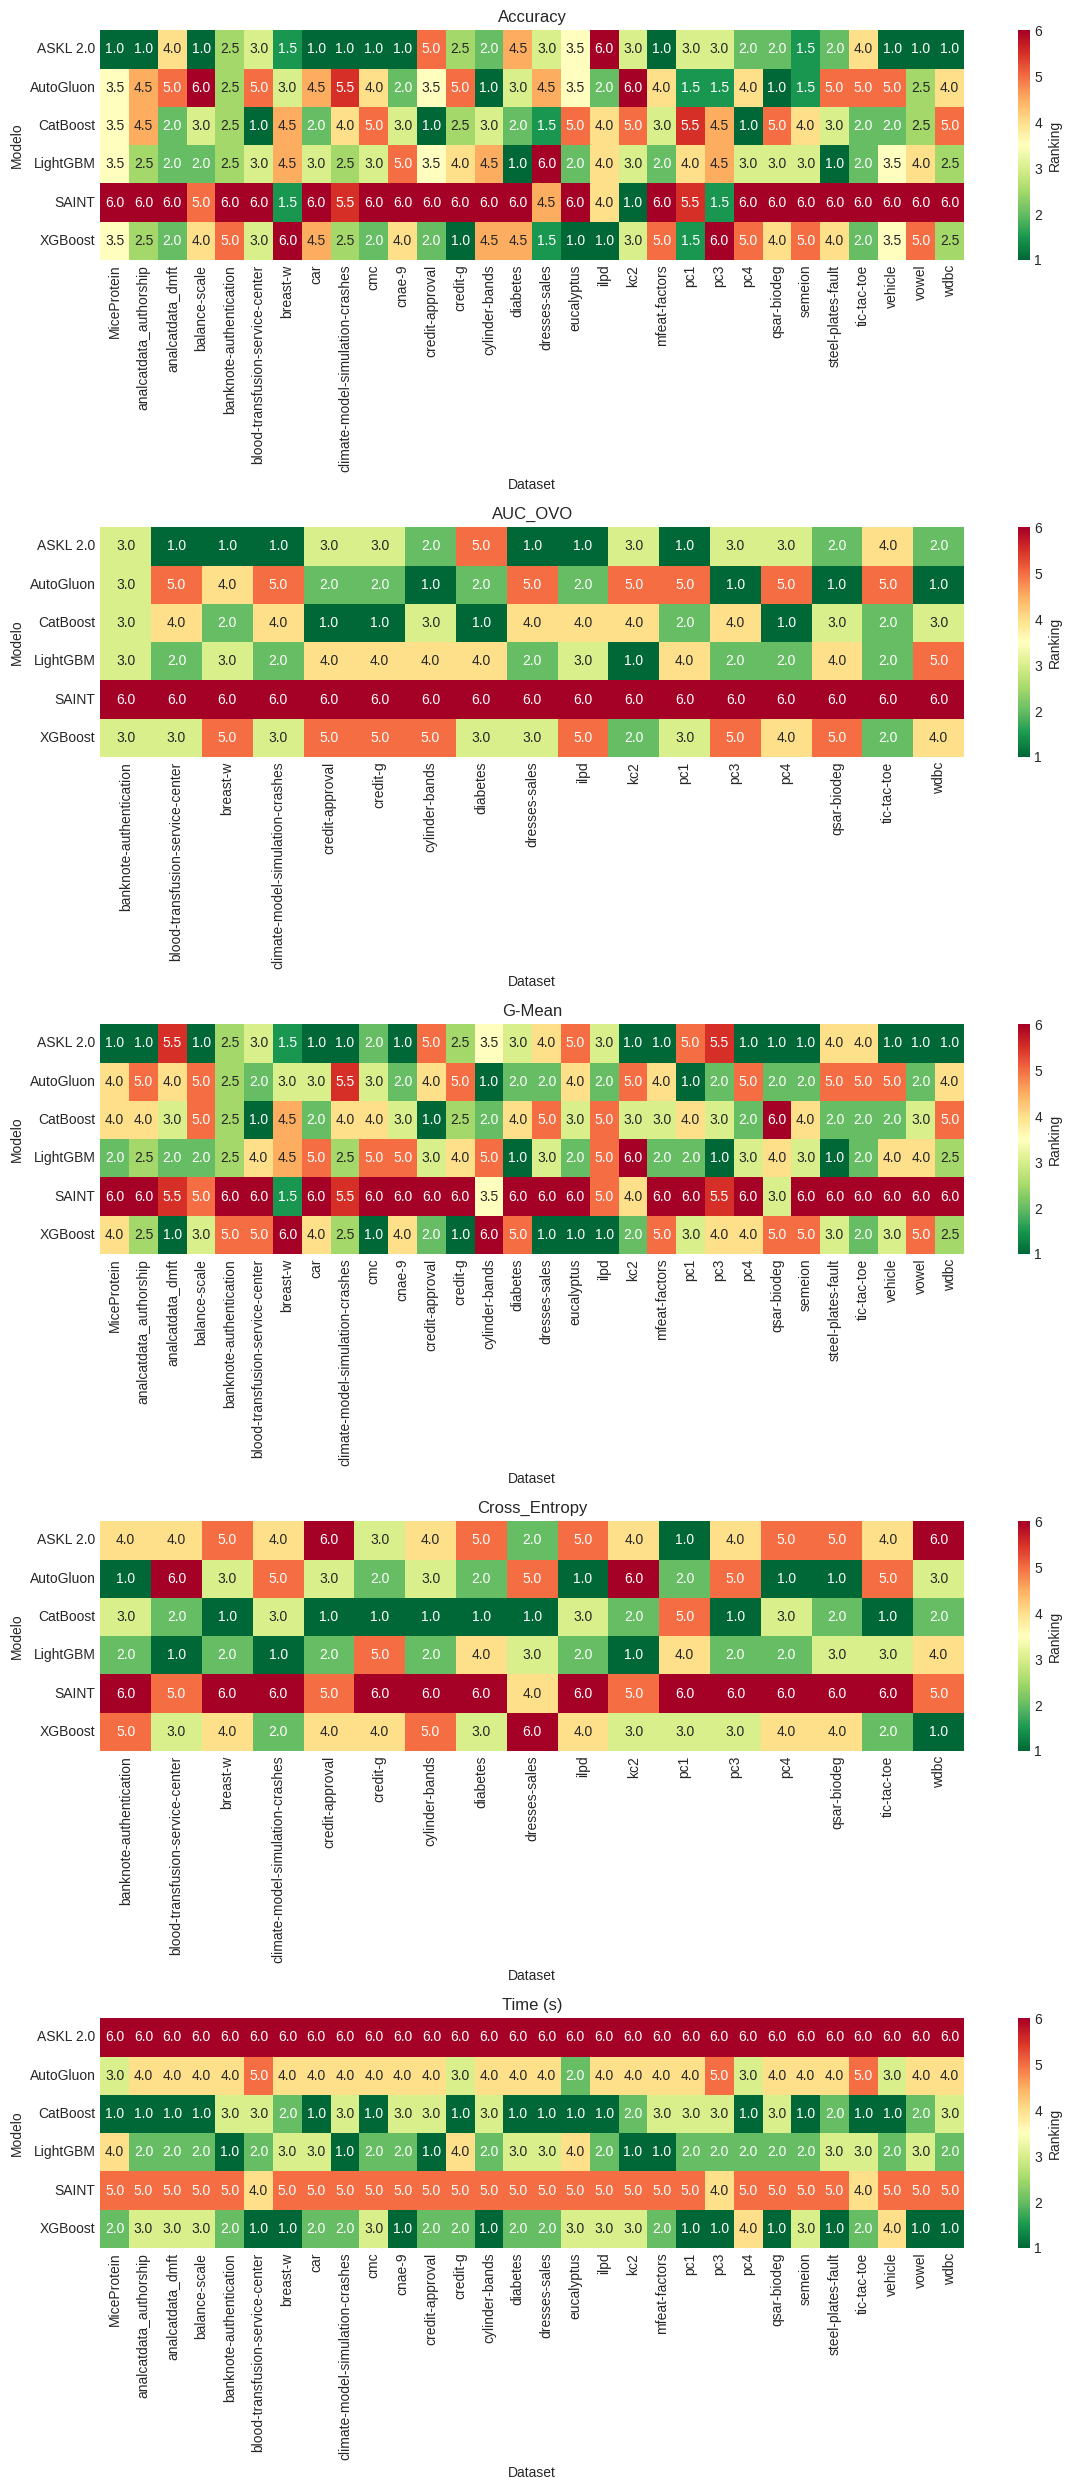

In [49]:
ranking_metrics = [
    ('Accuracy', True),
    ('AUC_OVO', True),
    ('G-Mean', True),
    ('Cross_Entropy', False),
    ('Time (s)', False)
]

fig, axes = plt.subplots(len(ranking_metrics), 1, figsize=(12, 5 * len(ranking_metrics)))

for ax, (metric, maximize) in zip(np.atleast_1d(axes), ranking_metrics):
	pivot = results_df.pivot(index='Dataset', columns='Model', values=metric).dropna()
	if pivot.empty:
		ax.set_axis_off()
		ax.set_title(f'Sem dados: {metric}')
		continue

	ranks = pivot.apply(lambda row: (-row).rank() if maximize else row.rank(), axis=1)
	sns.heatmap(
		ranks.T,
		annot=True,
		fmt='.1f',
		cmap='RdYlGn_r',
		ax=ax,
		cbar_kws={'label': 'Ranking'}
	)
	ax.set_title(metric)
	ax.set_xlabel('Dataset')
	ax.set_ylabel('Modelo')

plt.tight_layout()
plt.show()

### Painel de métricas

Mostra barras com média e desvio-padrão de cada métrica por modelo. No caso do Tempo total, quanto menor, melhor.

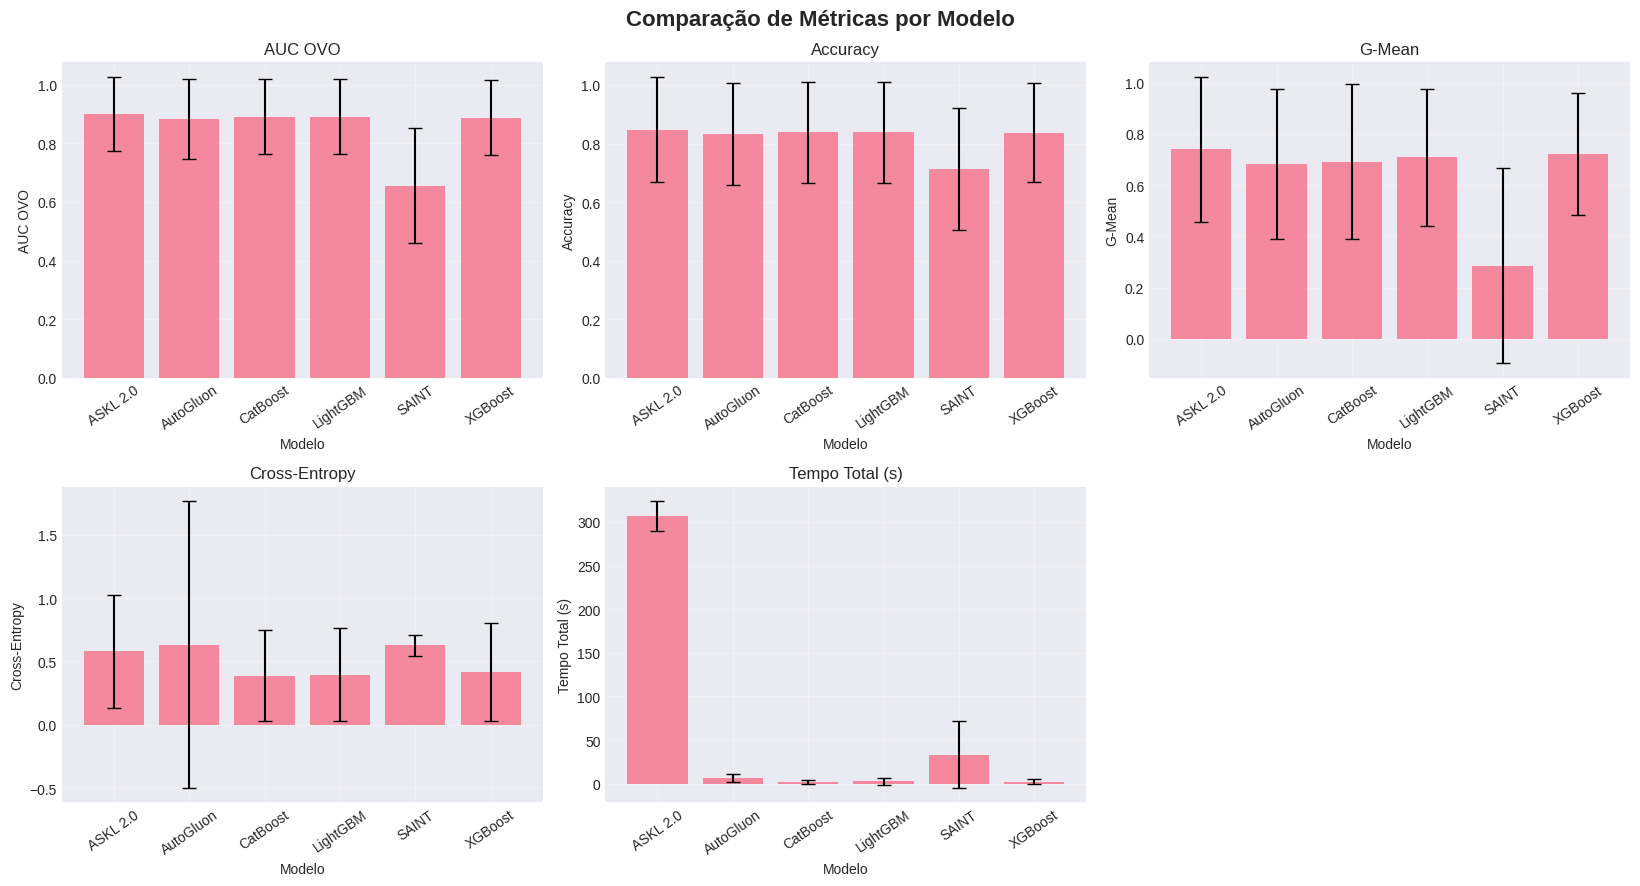

In [50]:
metric_panels = [
    ('AUC_OVO', 'AUC OVO'),
    ('Accuracy', 'Accuracy'),
    ('G-Mean', 'G-Mean'),
    ('Cross_Entropy', 'Cross-Entropy'),
    ('Time (s)', 'Tempo Total (s)')
]

rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5.5, rows * 4.5))
fig.suptitle('Comparação de Métricas por Modelo', fontsize=16, fontweight='bold')

for idx, (metric, title) in enumerate(metric_panels):
	r, c = divmod(idx, cols)
	ax = axes[r, c]
	data = results_df.groupby('Model')[metric].agg(['mean', 'std']).reset_index()
	ax.bar(data['Model'], data['mean'], yerr=data['std'], capsize=5, alpha=0.8)
	ax.set_title(title)
	ax.set_ylabel(title)
	ax.set_xlabel('Modelo')
	ax.tick_params(axis='x', rotation=35)
	ax.grid(True, alpha=0.3)

# remover subplot vazio
if len(metric_panels) < rows * cols:
	for k in range(len(metric_panels), rows * cols):
		fig.delaxes(axes.flatten()[k])

plt.tight_layout()
plt.show()


## Análise estatística (protocolo de Demšar)

Baseado no artigo *"Statistical Comparisons of Classifiers over Multiple Data Sets"*, realizamos a comparação estatística dos modelos seguindo o protocolo recomendado para múltiplos classificadores em múltiplos datasets:

1.  **Ranking:** Calculamos o posto (rank) de cada modelo para cada dataset.
2.  **Teste de Friedman (Iman-Davenport):** Verificamos se existe diferença significativa global entre os algoritmos.
    *   Hipótese Nula ($H_0$): Todos os algoritmos têm desempenho equivalente.
3.  **Teste de Nemenyi (Post-hoc):** Se $H_0$ for rejeitada, calculamos a Diferença Crítica (CD).
    *   Dois algoritmos são significativamente diferentes se a distância entre seus ranks médios for maior que a CD.
4.  **Visualização (CD Diagram):** Plotamos os ranks médios e conectamos modelos estatisticamente equivalentes.

## Teste de Friedman

O teste de Friedman é um teste não paramétrico para detectar diferenças em tratamentos (modelos) em múltiplas tentativas (datasets).
Hipótese Nula ($H_0$): Não há diferença significativa entre o desempenho dos modelos.

## Teste de Nemenyi

Como $H_0$ foi rejeitada, realizamos o teste de Nemenyi para identificar quais pares de modelos diferem significativamente.
Este teste compara as classificações médias de todos os pares de modelos.

### Critical Difference Diagram

O diagrama mostra a classificação média de cada modelo.
Modelos conectados por uma barra horizontal grossa não são estatisticamente diferentes (p > 0.05).


--- Análise Estatística para: AUC_OVO ---
    ! Removidos 13 datasets com resultados incompletos.

Ranks Médios (menor é melhor):
Model
ASKL 2.0     2.294118
CatBoost     2.705882
LightGBM     3.000000
AutoGluon    3.176471
XGBoost      3.823529
SAINT        6.000000
dtype: float64

Teste de Friedman: Estatística=44.5096, p-value=1.8251e-08
H0 rejeitada: Existem diferenças significativas entre os modelos.

Teste de Nemenyi (p-values) [α=0.05]:
Diferenças significativas encontradas:
  ASKL 2.0 vs SAINT: p=1.0000e-03
  AutoGluon vs SAINT: p=1.0000e-03
  CatBoost vs SAINT: p=1.0000e-03
  LightGBM vs SAINT: p=1.0000e-03
  SAINT vs XGBoost: p=9.0770e-03

Gerando Diagrama de Diferença Crítica...


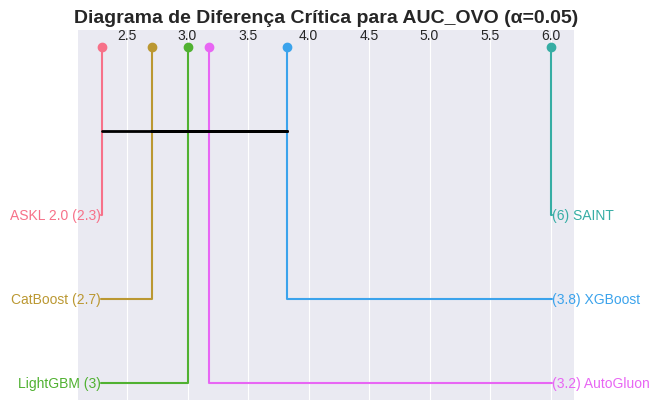


--- Análise Estatística para: Accuracy ---

Ranks Médios (menor é melhor):
Model
ASKL 2.0     2.300000
LightGBM     3.133333
CatBoost     3.216667
XGBoost      3.366667
AutoGluon    3.633333
SAINT        5.350000
dtype: float64

Teste de Friedman: Estatística=46.5739, p-value=6.9391e-09
H0 rejeitada: Existem diferenças significativas entre os modelos.

Teste de Nemenyi (p-values) [α=0.05]:
Diferenças significativas encontradas:
  ASKL 2.0 vs SAINT: p=1.0000e-03
  AutoGluon vs SAINT: p=5.0990e-03
  CatBoost vs SAINT: p=1.0000e-03
  LightGBM vs SAINT: p=1.0000e-03
  SAINT vs XGBoost: p=1.0000e-03

Gerando Diagrama de Diferença Crítica...


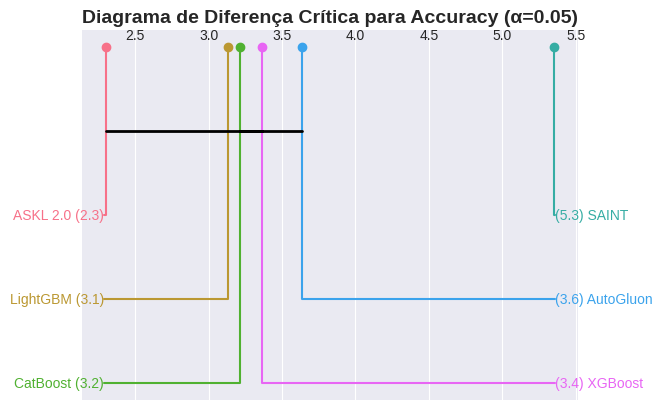


--- Análise Estatística para: G-Mean ---

Ranks Médios (menor é melhor):
Model
ASKL 2.0     2.433333
LightGBM     3.150000
CatBoost     3.283333
XGBoost      3.283333
AutoGluon    3.366667
SAINT        5.483333
dtype: float64

Teste de Friedman: Estatística=47.0907, p-value=5.4446e-09
H0 rejeitada: Existem diferenças significativas entre os modelos.

Teste de Nemenyi (p-values) [α=0.05]:
Diferenças significativas encontradas:
  ASKL 2.0 vs SAINT: p=1.0000e-03
  AutoGluon vs SAINT: p=1.0000e-03
  CatBoost vs SAINT: p=1.0000e-03
  LightGBM vs SAINT: p=1.0000e-03
  SAINT vs XGBoost: p=1.0000e-03

Gerando Diagrama de Diferença Crítica...


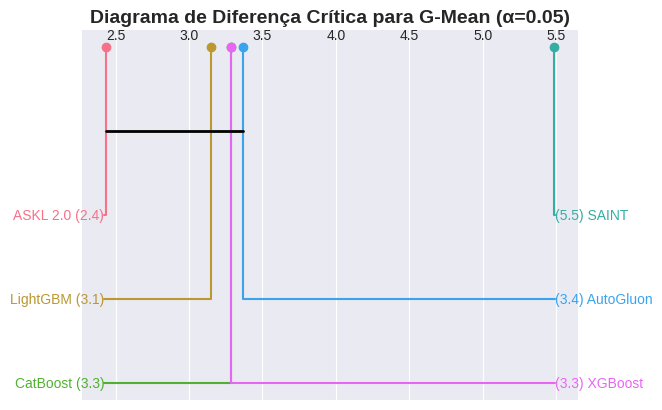

In [52]:
import scikit_posthocs as sp
import scipy.stats as stats

ALPHA = 0.05

for metric in ['AUC_OVO', 'Accuracy', 'G-Mean']:
	print(f"\n--- Análise Estatística para: {metric} ---")

	# Pivotar: linhas=datasets, colunas=modelos
	pivot_df = results_df.pivot(index='Dataset', columns='Model', values=metric)

	# Drop datasets with missing results (NaNs)
	original_len = len(pivot_df)
	pivot_df = pivot_df.dropna()
	if len(pivot_df) < original_len:
		print(f"    ! Removidos {original_len - len(pivot_df)} datasets com resultados incompletos.")
	if len(pivot_df) == 0:
		print("    ! Nenhum dataset completo para análise estatística.")
		continue

	# Ranking (maior valor = melhor rank, então ascending=False para rank 1 ser o melhor)
	ranks = pivot_df.rank(axis=1, ascending=False)
	avg_ranks = ranks.mean()

	print("\nRanks Médios (menor é melhor):")
	print(avg_ranks.sort_values())

	# Teste de Friedman
	args = [pivot_df[col] for col in pivot_df.columns]
	stat, p_value = stats.friedmanchisquare(*args)

	print(f"\nTeste de Friedman: Estatística={stat:.4f}, p-value={p_value:.4e}")

	reject_h0 = p_value < ALPHA
	if reject_h0:
		print("H0 rejeitada: Existem diferenças significativas entre os modelos.")
	else:
		print("H0 não rejeitada: Não há evidências suficientes de diferença.")
		continue

	# Post-hoc Nemenyi
	if reject_h0:
		nemenyi_matrix = sp.posthoc_nemenyi_friedman(pivot_df)
		
		print(f"\nTeste de Nemenyi (p-values) [α={ALPHA}]:")
		sig_pairs = []
		cols = nemenyi_matrix.columns
		for i in range(len(cols)):
			for j in range(i+1, len(cols)):
				p = nemenyi_matrix.iloc[i, j]
				if p < ALPHA:
					sig_pairs.append((cols[i], cols[j], p))
		
		if sig_pairs:
			print("Diferenças significativas encontradas:")
			for m1, m2, p in sig_pairs:
				print(f"  {m1} vs {m2}: p={p:.4e}")
		else:
			print("Nenhuma diferença par-a-par significativa encontrada pelo Nemenyi.")

		# CD Diagram
		print("\nGerando Diagrama de Diferença Crítica...")

		fig = sp.critical_difference_diagram(avg_ranks, nemenyi_matrix)
		plt.title(f'Diagrama de Diferença Crítica para {metric} (α={ALPHA})', fontsize=14, fontweight='bold')
		plt.show()